In [43]:
# Import
# ======

# essential libraries
import math
import random
from datetime import timedelta

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# importing datasets
# ==================

full_table = pd.read_csv('covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.sample(6)

Province/State  Country/Region      Lat      Long       Date  Confirmed  \
12961            NaN           Niger  17.6078    8.0817 2020-03-11          0   
7365          Hainan           China  19.1959  109.7453 2020-02-19        168   
544              NaN         Belarus  53.7098   27.9534 2020-01-24          0   
6485     Isle of Man  United Kingdom  54.2361   -4.5481 2020-02-15          0   
8754             NaN      Kazakhstan  48.0196   66.9237 2020-02-24          0   
2524             NaN          Norway  60.4720    8.4689 2020-01-31          0   

       Deaths  Recovered  
12961       0          0  
7365        4         84  
544         0          0  
6485        0          0  
8754        0          0  
2524        0          0

In [5]:
# dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19836 entries, 0 to 19835
Data columns (total 8 columns):
Province/State    6080 non-null object
Country/Region    19836 non-null object
Lat               19836 non-null float64
Long              19836 non-null float64
Date              19836 non-null datetime64[ns]
Confirmed         19836 non-null int64
Deaths            19836 non-null int64
Recovered         19836 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.2+ MB


In [8]:
# checking for missing value
full_table.isna().sum()

Province/State    13756
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

# Preprocessing

In [9]:
# Ship
# ====

# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# full table 
full_table = full_table[~(ship_rows)]

# Latest cases from the ships
ship_latest = ship[ship['Date']==max(ship['Date'])]

# ship_latest.style.background_gradient(cmap='Pastel1_r')

In [10]:
# Cleaning data
# =============

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed', 'Deaths', 'Recovered', 'Active']] = full_table[['Confirmed', 'Deaths', 'Recovered', 'Active']].fillna(0)

# fixing datatypes
full_table['Recovered'] = full_table['Recovered'].astype(int)

full_table.sample(6)

Province/State  Country/Region      Lat     Long       Date  Confirmed  \
17341     Martinique          France  14.6415 -61.0242 2020-03-28         93   
13271    Isle of Man  United Kingdom  54.2361  -4.5481 2020-03-12          0   
3534                      Kazakhstan  48.0196  66.9237 2020-02-04          0   
15657                    South Sudan   6.8770  31.3070 2020-03-21          0   
18039                       Bulgaria  42.7339  25.4858 2020-03-31        399   
978                       Seychelles  -4.6796  55.4920 2020-01-25          0   

       Deaths  Recovered  Active  
17341       1          0      92  
13271       0          0       0  
3534        0          0       0  
15657       0          0       0  
18039       8         17     374  
978         0          0       0

In [12]:
# Grouped by day, country
# =======================

full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# new cases ======================================================
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# =================================================================

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])

# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

full_grouped.head()

Date Country/Region  Confirmed  Deaths  Recovered  Active  New cases  \
0 2020-01-22    Afghanistan          0       0          0       0          0   
1 2020-01-22        Albania          0       0          0       0          0   
2 2020-01-22        Algeria          0       0          0       0          0   
3 2020-01-22        Andorra          0       0          0       0          0   
4 2020-01-22         Angola          0       0          0       0          0   

   New deaths  New recovered  
0           0              0  
1           0              0  
2           0              0  
3           0              0  
4           0              0

In [13]:
# Day wise
# ========

# table
day_wise = full_grouped.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases'].sum().reset_index()

# number cases per 100 cases
day_wise['Deaths / 100 Cases'] = round((day_wise['Deaths']/day_wise['Confirmed'])*100, 2)
day_wise['Recovered / 100 Cases'] = round((day_wise['Recovered']/day_wise['Confirmed'])*100, 2)
day_wise['Deaths / 100 Recovered'] = round((day_wise['Deaths']/day_wise['Recovered'])*100, 2)

# no. of countries
day_wise['No. of countries'] = full_grouped[full_grouped['Confirmed']!=0].groupby('Date')['Country/Region'].unique().apply(len).values

# fillna by 0
cols = ['Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered']
day_wise[cols] = day_wise[cols].fillna(0)

day_wise.head()

Date  Confirmed  Deaths  Recovered  Active  New cases  \
0 2020-01-22        555      17         28     510          0   
1 2020-01-23        654      18         30     606         99   
2 2020-01-24        941      26         36     879        287   
3 2020-01-25       1434      42         39    1353        493   
4 2020-01-26       2118      56         52    2010        684   

   Deaths / 100 Cases  Recovered / 100 Cases  Deaths / 100 Recovered  \
0                3.06                   5.05                   60.71   
1                2.75                   4.59                   60.00   
2                2.76                   3.83                   72.22   
3                2.93                   2.72                  107.69   
4                2.64                   2.46                  107.69   

   No. of countries  
0                 6  
1                 8  
2                 9  
3                11  
4                13

In [14]:
# Country wise
# ============

# getting latest values
country_wise = full_grouped[full_grouped['Date']==max(full_grouped['Date'])].reset_index(drop=True).drop('Date', axis=1)

# group by country
country_wise = country_wise.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases'].sum().reset_index()

# per 100 cases
country_wise['Deaths / 100 Cases'] = round((country_wise['Deaths']/country_wise['Confirmed'])*100, 2)
country_wise['Recovered / 100 Cases'] = round((country_wise['Recovered']/country_wise['Confirmed'])*100, 2)
country_wise['Deaths / 100 Recovered'] = round((country_wise['Deaths']/country_wise['Recovered'])*100, 2)

cols = ['Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered']
country_wise[cols] = country_wise[cols].fillna(0)

country_wise.head()

Country/Region  Confirmed  Deaths  Recovered  Active  New cases  \
0    Afghanistan        367      11         18     338         18   
1        Albania        377      21        116     240         16   
2        Algeria       1423     173         90    1160        103   
3        Andorra        525      21         31     473         24   
4         Angola         16       2          2      12          2   

   Deaths / 100 Cases  Recovered / 100 Cases  Deaths / 100 Recovered  
0                3.00                   4.90                   61.11  
1                5.57                  30.77                   18.10  
2               12.16                   6.32                  192.22  
3                4.00                   5.90                   67.74  
4               12.50                  12.50                  100.00

In [ ]:
# load population dataset
pop = pd.read_csv("population_by_country_2020.csv")

# select only population
pop = pop.iloc[:, :2]

# rename column names
pop.columns = ['Country/Region', 'Population']

# merged data
country_wise = pd.merge(country_wise, pop, on='Country/Region', how='left')

# update population
cols = ['Burma', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Czechia', 
        'Kosovo', 'Saint Kitts and Nevis', 'Saint Vincent and the Grenadines', 
        'Taiwan*', 'US', 'West Bank and Gaza']
pops = [54409800, 89561403, 5518087, 26378274, 10708981, 1793000, 
        53109, 110854, 23806638, 330541757, 4543126]
for c, p in zip(cols, pops):
    country_wise.loc[country_wise['Country/Region']== c, 'Population'] = p
    
# missing values
# country_wise.isna().sum()
# country_wise[country_wise['Population'].isna()]['Country/Region'].tolist()

# Cases per population
country_wise['Cases / Million People'] = round((country_wise['Confirmed'] / country_wise['Population']) * 1000000)

country_wise.head()

In [18]:
today = full_grouped[full_grouped['Date']==max(full_grouped['Date'])].reset_index(drop=True).drop('Date', axis=1)[['Country/Region', 'Confirmed']]
last_week = full_grouped[full_grouped['Date']==max(full_grouped['Date'])-timedelta(days=7)].reset_index(drop=True).drop('Date', axis=1)[['Country/Region', 'Confirmed']]

temp = pd.merge(today, last_week, on='Country/Region', suffixes=(' today', ' last week'))

# temp = temp[['Country/Region', 'Confirmed last week']]
temp['1 week change'] = temp['Confirmed today'] - temp['Confirmed last week']

temp = temp[['Country/Region', 'Confirmed last week', '1 week change']]

country_wise = pd.merge(country_wise, temp, on='Country/Region')

country_wise['1 week % increase'] = round(country_wise['1 week change']/country_wise['Confirmed last week']*100, 2)

country_wise.head()

Country/Region  Confirmed  Deaths  Recovered  Active  New cases  \
0    Afghanistan        367      11         18     338         18   
1        Albania        377      21        116     240         16   
2        Algeria       1423     173         90    1160        103   
3        Andorra        525      21         31     473         24   
4         Angola         16       2          2      12          2   

   Deaths / 100 Cases  Recovered / 100 Cases  Deaths / 100 Recovered  \
0                3.00                   4.90                   61.11   
1                5.57                  30.77                   18.10   
2               12.16                   6.32                  192.22   
3                4.00                   5.90                   67.74   
4               12.50                  12.50                  100.00   

   Confirmed last week  1 week change  1 week % increase  
0                  170            197             115.88  
1                  223            154              69.06  
2                  584            839             143.66  
3                  370            155              41.89  
4                    7              9             128.57

In [19]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)

tm = temp.melt(id_vars="Date", value_vars=['Active', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=225, width=640,
                 color_discrete_sequence=[act, rec, dth])
fig.data[0].textinfo = 'label+text+value'
fig.show()

AttributeError: module 'plotly.express' has no attribute 'treemap'

In [22]:
vendors = ["A", "B", "C", "D", None, "E", "F", "G", "H", None]
sectors = ["Tech", "Tech", "Finance", "Finance", "Other",
        "Tech", "Tech", "Finance", "Finance", "Other"]
regions = ["North", "North", "North", "North", "North",
        "South", "South", "South", "South", "South"]
sales = [1, 3, 2, 4, 1, 2, 2, 1, 4, 1]
df = pd.DataFrame(
    dict(vendors=vendors, sectors=sectors, regions=regions, sales=sales)
)
df["all"] = "all"  # in order to have a single root node

print(df)
fig = px.treemap(df, path=['all', 'regions',
                        'sectors', 'vendors'], values='sales')
fig.show()

  vendors  sectors regions  sales  all
0       A     Tech   North      1  all
1       B     Tech   North      3  all
2       C  Finance   North      2  all
3       D  Finance   North      4  all
4    None    Other   North      1  all
5       E     Tech   South      2  all
6       F     Tech   South      2  all
7       G  Finance   South      1  all
8       H  Finance   South      4  all
9    None    Other   South      1  all


AttributeError: module 'plotly.express' has no attribute 'treemap'

In [ ]:
temp = full_table.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case', height=800,
             title='Cases over time', color_discrete_sequence = [rec, dth, act])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [23]:
temp = full_table[full_table['Date'] == max(full_table['Date'])]

m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Lat'], temp.iloc[i]['Long']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(temp.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Deaths']),
        radius=int(temp.iloc[i]['Confirmed'])**1.1).add_to(m)

In [24]:
# Over the time

fig = px.choropleth(full_grouped, locations="Country/Region", locationmode='country names', color=np.log(full_grouped["Confirmed"]), 
                    hover_name="Country/Region", animation_frame=full_grouped["Date"].dt.strftime('%Y-%m-%d'),
                    title='Cases over time', color_continuous_scale=px.colors.sequential.Magenta)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [25]:
# Confirmed
fig_c = px.choropleth(country_wise, locations="Country/Region", locationmode='country names', 
                      color=np.log(country_wise["Confirmed"]), hover_name="Country/Region", hover_data=['Confirmed'])

# Deaths
temp = country_wise[country_wise['Deaths']>0]
fig_d = px.choropleth(temp, locations="Country/Region", locationmode='country names',
                      color=np.log(temp["Deaths"]), hover_name="Country/Region", hover_data=['Deaths'])

# Plot
fig = make_subplots(rows=1, cols=2, subplot_titles = ['Confirmed', 'Deaths'],
                    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]])

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)

fig.update(layout_coloraxis_showscale=False)

fig.show()

## Cases over the time

In [26]:
fig_c = px.bar(day_wise, x="Date", y="Confirmed", color_discrete_sequence = [act])
fig_d = px.bar(day_wise, x="Date", y="Deaths", color_discrete_sequence = [dth])

fig = make_subplots(rows=1, cols=2, shared_xaxes=False, horizontal_spacing=0.1,
                    subplot_titles=('Confirmed cases', 'Deaths reported'))

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)

fig.update_layout(height=480)

# ===============================

fig_1 = px.line(day_wise, x="Date", y="Deaths / 100 Cases", color_discrete_sequence = [dth])
fig_2 = px.line(day_wise, x="Date", y="Recovered / 100 Cases", color_discrete_sequence = [rec])
fig_3 = px.line(day_wise, x="Date", y="Deaths / 100 Recovered", color_discrete_sequence = ['#333333'])

fig = make_subplots(rows=1, cols=3, shared_xaxes=False, 
                    subplot_titles=('Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered'))

fig.add_trace(fig_1['data'][0], row=1, col=1)
fig.add_trace(fig_2['data'][0], row=1, col=2)
fig.add_trace(fig_3['data'][0], row=1, col=3)

fig.update_layout(height=480)

# ===================================

fig_c = px.bar(day_wise, x="Date", y="New cases", color_discrete_sequence = [act])
fig_d = px.bar(day_wise, x="Date", y="No. of countries", color_discrete_sequence = [dth])

fig = make_subplots(rows=1, cols=2, shared_xaxes=False, horizontal_spacing=0.1,
                    subplot_titles=('No. of new cases everyday', 'No. of countries'))

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)

fig.update_layout(height=480)

## Top 20 Countries

In [27]:
# confirmed - deaths
fig_c = px.bar(country_wise.sort_values('Confirmed').tail(15), x="Confirmed", y="Country/Region", 
               text='Confirmed', orientation='h', color_discrete_sequence = [act])
fig_d = px.bar(country_wise.sort_values('Deaths').tail(15), x="Deaths", y="Country/Region", 
               text='Deaths', orientation='h', color_discrete_sequence = [dth])

# recovered - active
fig_r = px.bar(country_wise.sort_values('Recovered').tail(15), x="Recovered", y="Country/Region", 
               text='Recovered', orientation='h', color_discrete_sequence = [rec])
fig_a = px.bar(country_wise.sort_values('Active').tail(15), x="Active", y="Country/Region", 
               text='Active', orientation='h', color_discrete_sequence = ['#333333'])

# death - recoverd / 100 cases
fig_dc = px.bar(country_wise.sort_values('Deaths / 100 Cases').tail(15), x="Deaths / 100 Cases", y="Country/Region", 
               text='Deaths / 100 Cases', orientation='h', color_discrete_sequence = ['#f38181'])
fig_rc = px.bar(country_wise.sort_values('Recovered / 100 Cases').tail(15), x="Recovered / 100 Cases", y="Country/Region", 
               text='Recovered / 100 Cases', orientation='h', color_discrete_sequence = ['#a3de83'])

# new cases - cases per million people
fig_nc = px.bar(country_wise.sort_values('New cases').tail(15), x="New cases", y="Country/Region", 
               text='New cases', orientation='h', color_discrete_sequence = ['#c61951'])
temp = country_wise[country_wise['Population']>1000000]
fig_p = px.bar(temp.sort_values('Cases / Million People').tail(15), x="Cases / Million People", y="Country/Region", 
               text='Cases / Million People', orientation='h', color_discrete_sequence = ['#741938'])

# week change, percent increase
fig_wc = px.bar(country_wise.sort_values('1 week change').tail(15), x="1 week change", y="Country/Region", 
               text='1 week change', orientation='h', color_discrete_sequence = ['#004a7c'])
temp = country_wise[country_wise['Confirmed']>100]
fig_pi = px.bar(temp.sort_values('1 week % increase').tail(15), x="1 week % increase", y="Country/Region", 
               text='1 week % increase', orientation='h', color_discrete_sequence = ['#005691'], 
                hover_data=['Confirmed last week', 'Confirmed'])


# plot
fig = make_subplots(rows=5, cols=2, shared_xaxes=False, horizontal_spacing=0.14, vertical_spacing=0.08,
                    subplot_titles=('Confirmed cases', 'Deaths reported', 'Recovered', 'Active cases', 
                                    'Deaths / 100 cases', 'Recovered / 100 cases', 'New cases', 
                                    'Cases / Million People', '1 week increase', '1 week % increase'))

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)
fig.add_trace(fig_r['data'][0], row=2, col=1)
fig.add_trace(fig_a['data'][0], row=2, col=2)

fig.add_trace(fig_dc['data'][0], row=3, col=1)
fig.add_trace(fig_rc['data'][0], row=3, col=2)
fig.add_trace(fig_nc['data'][0], row=4, col=1)
fig.add_trace(fig_p['data'][0], row=4, col=2)

fig.add_trace(fig_wc['data'][0], row=5, col=1)
fig.add_trace(fig_pi['data'][0], row=5, col=2)


fig.update_layout(height=3000)

KeyError: 'Population'

In [28]:
fig = px.scatter(country_wise.sort_values('Deaths', ascending=False).iloc[:15, :], 
                 x='Confirmed', y='Deaths', color='Country/Region', size='Confirmed', height=700,
                 text='Country/Region', log_x=True, log_y=True, title='Deaths vs Confirmed (Scale is in log10)')
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [29]:
fig = px.line(full_grouped, x="Date", y="Confirmed", color='Country/Region', height=600,
             title='Confirmed', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()

# =========================================

fig = px.line(full_grouped, x="Date", y="Deaths", color='Country/Region', height=600,
             title='Deaths', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()

# =========================================

fig = px.line(full_grouped, x="Date", y="New cases", color='Country/Region', height=600,
             title='New cases', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()

In [30]:
gt_100 = full_grouped[full_grouped['Confirmed']>100]['Country/Region'].unique()
temp = full_table[full_table['Country/Region'].isin(gt_100)]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()
temp = temp[temp['Confirmed']>100]
# print(temp.head())

min_date = temp.groupby('Country/Region')['Date'].min().reset_index()
min_date.columns = ['Country/Region', 'Min Date']
# print(min_date.head())

from_100th_case = pd.merge(temp, min_date, on='Country/Region')
from_100th_case['N days'] = (from_100th_case['Date'] - from_100th_case['Min Date']).dt.days
# print(from_100th_case.head())

fig = px.line(from_100th_case, x='N days', y='Confirmed', color='Country/Region', title='N days from 100 case', height=600)
fig.show()

# ===========================================================================

gt_1000 = full_grouped[full_grouped['Confirmed']>1000]['Country/Region'].unique()
temp = full_table[full_table['Country/Region'].isin(gt_1000)]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()
temp = temp[temp['Confirmed']>1000]
# print(temp.head())

min_date = temp.groupby('Country/Region')['Date'].min().reset_index()
min_date.columns = ['Country/Region', 'Min Date']
# print(min_date.head())

from_1000th_case = pd.merge(temp, min_date, on='Country/Region')
from_1000th_case['N days'] = (from_1000th_case['Date'] - from_1000th_case['Min Date']).dt.days
# print(from_1000th_case.head())

fig = px.line(from_1000th_case, x='N days', y='Confirmed', color='Country/Region', title='N days from 1000 case', height=600)
fig.show()

# ===========================================================================

gt_10000 = full_grouped[full_grouped['Confirmed']>10000]['Country/Region'].unique()
temp = full_table[full_table['Country/Region'].isin(gt_10000)]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()
temp = temp[temp['Confirmed']>10000]
# print(temp.head())

min_date = temp.groupby('Country/Region')['Date'].min().reset_index()
min_date.columns = ['Country/Region', 'Min Date']
# print(min_date.head())

from_10000th_case = pd.merge(temp, min_date, on='Country/Region')
from_10000th_case['N days'] = (from_10000th_case['Date'] - from_10000th_case['Min Date']).dt.days
# print(from_10000th_case.head())full_grouped

fig = px.line(from_10000th_case, x='N days', y='Confirmed', color='Country/Region', title='N days from 10000 case', height=600)
fig.show()

## Composition of Cases

In [31]:
full_latest = full_table[full_table['Date'] == max(full_table['Date'])]
                         
fig = px.treemap(full_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Confirmed", height=700,
                 title='Number of Confirmed Cases',
                 color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()

fig = px.treemap(full_latest.sort_values(by='Deaths', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Deaths", height=700,
                 title='Number of Deaths reported',
                 color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()

AttributeError: module 'plotly.express' has no attribute 'treemap'

In [32]:
temp = full_grouped[full_grouped['New cases']>0].sort_values('Country/Region', ascending=False)
fig = px.scatter(temp, x='Date', y='Country/Region', size='New cases', color='New cases', height=3000, 
           color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(yaxis = dict(dtick = 1))
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [33]:
# first date
# ==========
first_date = full_table[full_table['Confirmed']>0]
first_date = first_date.groupby('Country/Region')['Date'].agg(['min']).reset_index()
# first_date.head()

# last date
# =========
last_date = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
last_date = last_date.sum().diff().reset_index()

mask = last_date['Country/Region'] != last_date['Country/Region'].shift(1)
last_date.loc[mask, 'Confirmed'] = np.nan
last_date.loc[mask, 'Deaths'] = np.nan
last_date.loc[mask, 'Recovered'] = np.nan

last_date = last_date[last_date['Confirmed']>0]
last_date = last_date.groupby('Country/Region')['Date'].agg(['max']).reset_index()
# last_date.head()

# first_last
# ==========
first_last = pd.concat([first_date, last_date[['max']]], axis=1)

# added 1 more day, which will show the next day as the day on which last case appeared
first_last['max'] = first_last['max'] + timedelta(days=1)

# no. of days
first_last['Days'] = first_last['max'] - first_last['min']

# task column as country
first_last['Task'] = first_last['Country/Region']

# rename columns
first_last.columns = ['Country/Region', 'Start', 'Finish', 'Days', 'Task']

# sort by no. of days
first_last = first_last.sort_values('Days')
# first_last.head()

# visualization
# =============

# produce random colors
clr = ["#"+''.join([random.choice('0123456789ABC') for j in range(6)]) for i in range(len(first_last))]

# plot
fig = ff.create_gantt(first_last, index_col='Country/Region', colors=clr, show_colorbar=False, 
                      bar_width=0.2, showgrid_x=True, showgrid_y=True, height=2500)
fig.show()

# Country Wise

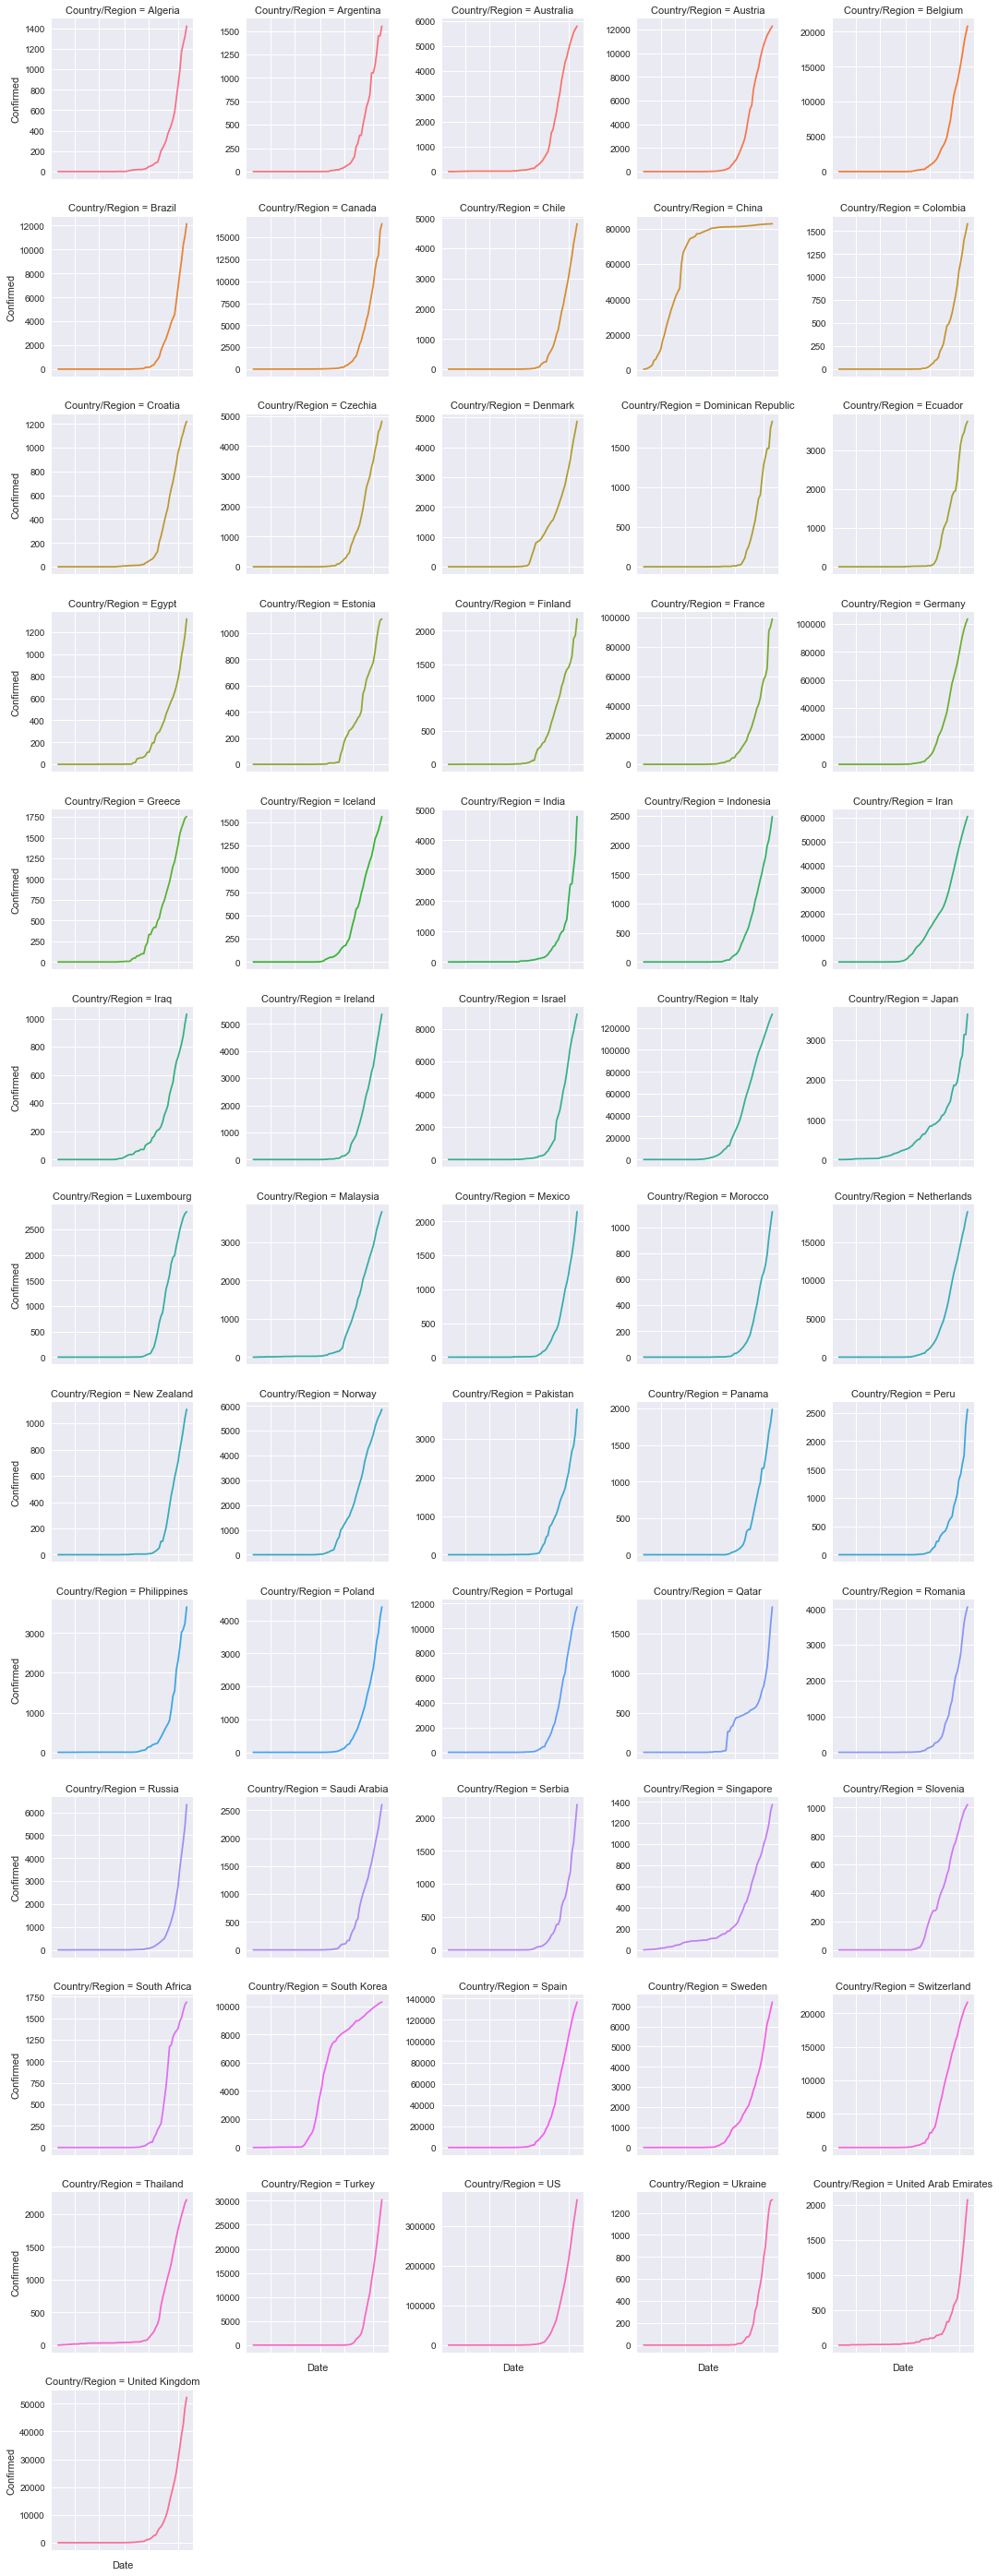

In [35]:
temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum()
temp = temp.reset_index().sort_values(by=['Date', 'Country/Region'])
temp = temp[temp['Country/Region'].isin(gt_1000)]

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region", sharey=False, col_wrap=5)
g = g.map(plt.plot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

### New cases (countries with > 1000 cases)

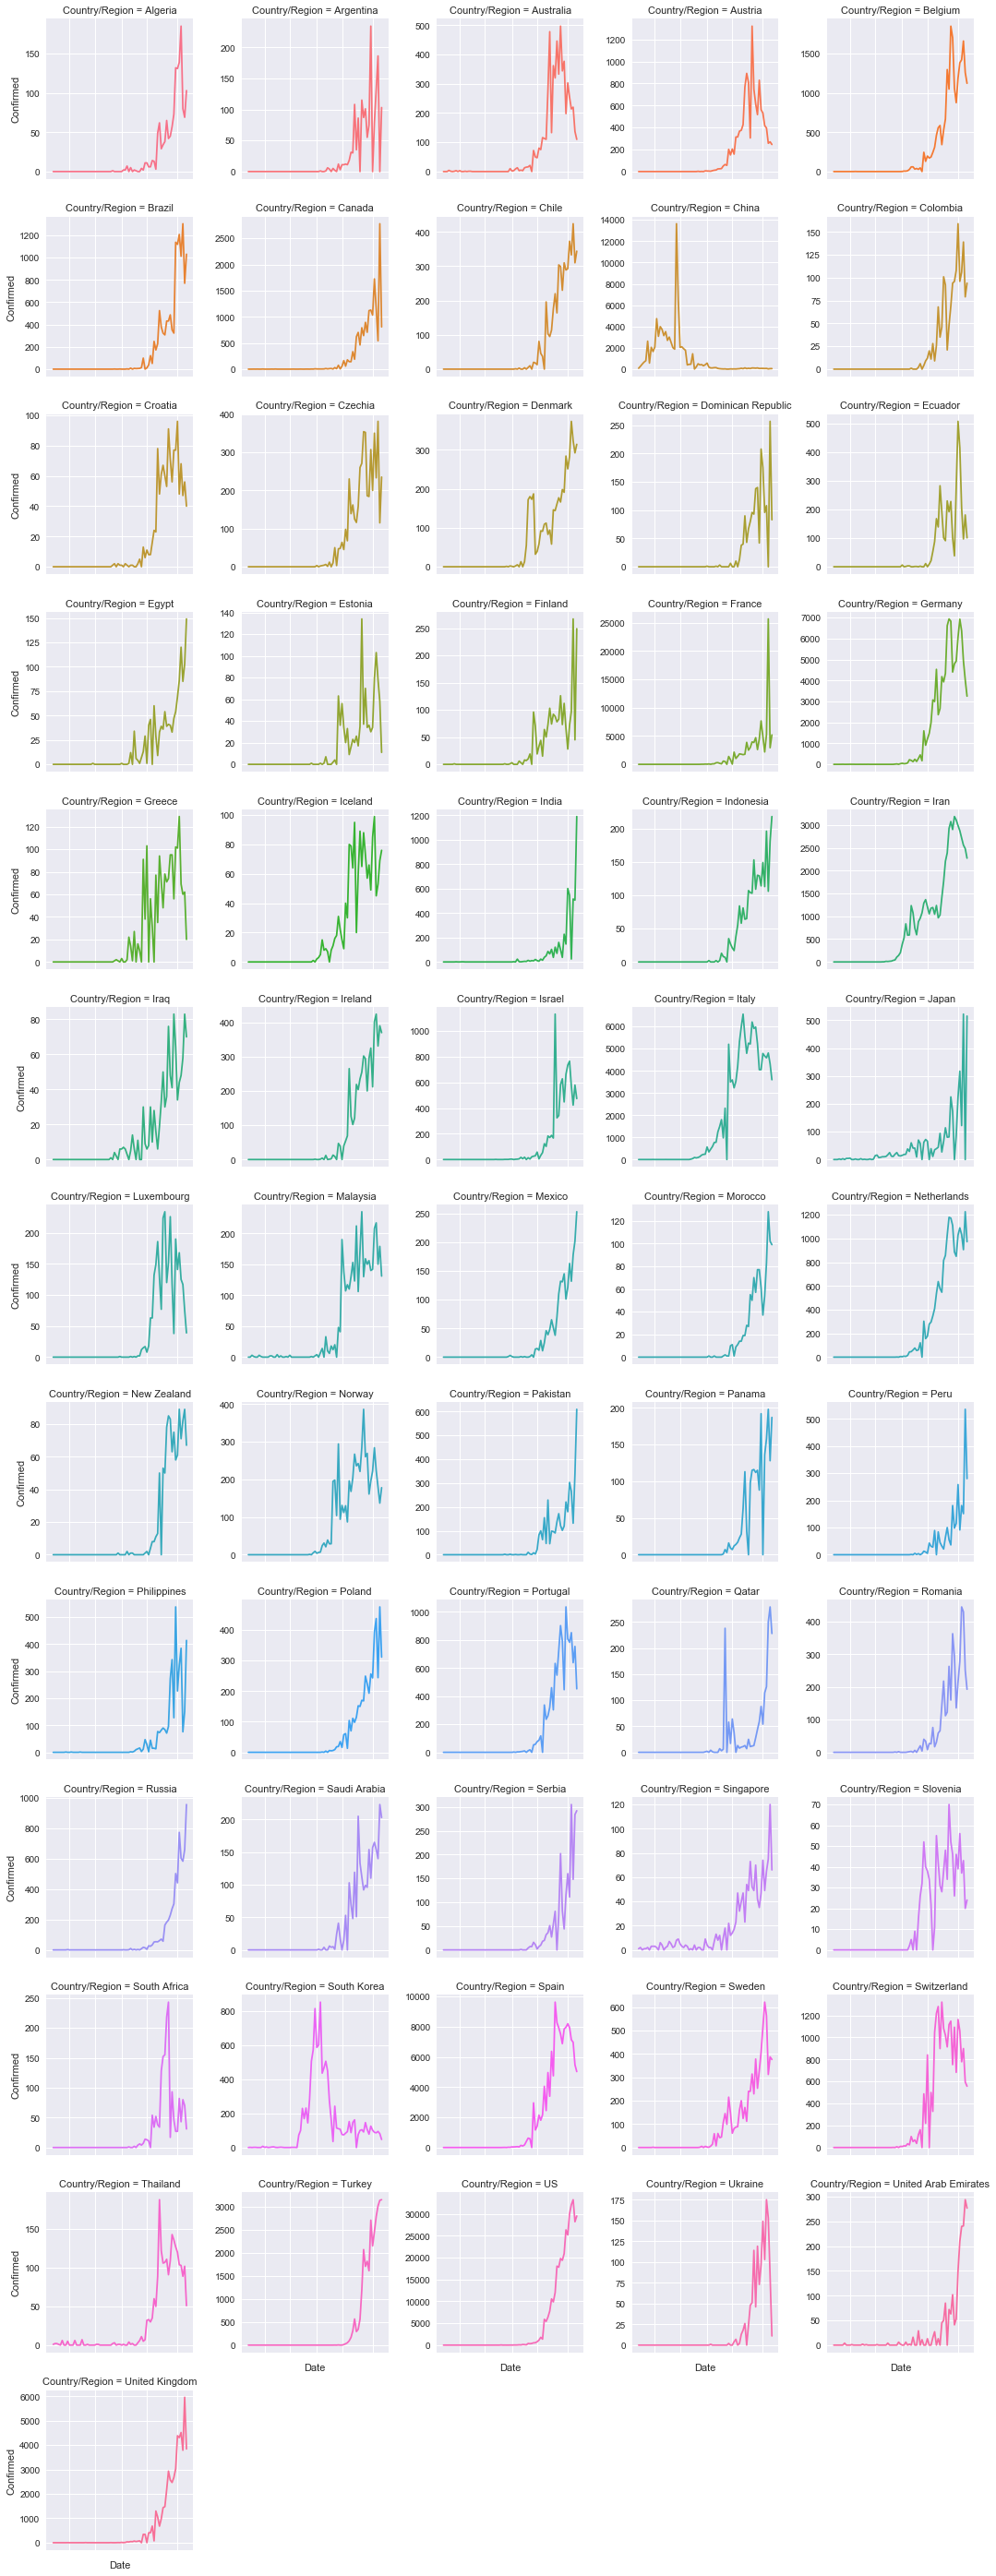

In [37]:
temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
temp = temp[temp['Country/Region'].isin(gt_1000)]

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region",  sharey=False, col_wrap=5)
g = g.map(sns.lineplot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

## Number of new cases every day

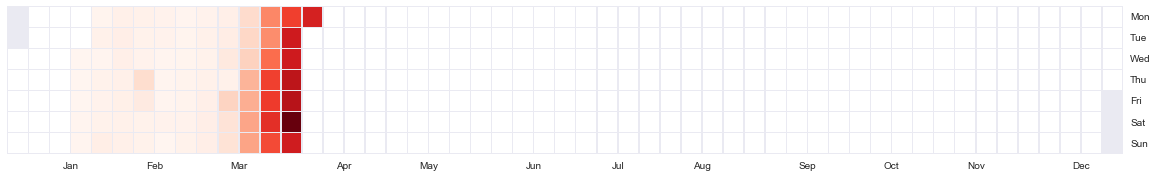

In [38]:
temp = full_table.groupby('Date')['Confirmed'].sum()
temp = temp.diff()

plt.figure(figsize=(20, 5))
ax = calmap.yearplot(temp, fillcolor='white', cmap='Reds', linewidth=0.5)

### Number of new countries every day

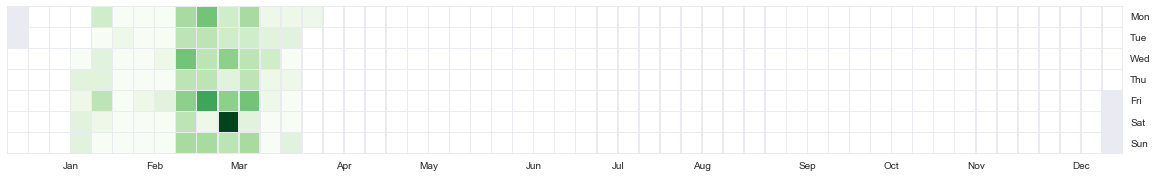

In [39]:
spread = full_table[full_table['Confirmed']!=0].groupby('Date')
spread = spread['Country/Region'].unique().apply(len).diff()

plt.figure(figsize=(20, 5))
ax = calmap.yearplot(spread, fillcolor='white', cmap='Greens', linewidth=0.5)

### Comparison with similar epidemics

In [40]:
epidemics = pd.DataFrame({
    'epidemic' : ['COVID-19', 'SARS', 'EBOLA', 'MERS', 'H1N1'],
    'start_year' : [2019, 2003, 2014, 2012, 2009],
    'end_year' : [2020, 2004, 2016, 2017, 2010],
    'confirmed' : [full_latest['Confirmed'].sum(), 8096, 28646, 2494, 6724149],
    'deaths' : [full_latest['Deaths'].sum(), 774, 11323, 858, 19654]
})

epidemics['mortality'] = round((epidemics['deaths']/epidemics['confirmed'])*100, 2)

epidemics.head()

epidemic  start_year  end_year  confirmed  deaths  mortality
0  COVID-19        2019      2020    1344312   74551       5.55
1      SARS        2003      2004       8096     774       9.56
2     EBOLA        2014      2016      28646   11323      39.53
3      MERS        2012      2017       2494     858      34.40
4      H1N1        2009      2010    6724149   19654       0.29

In [44]:
temp = epidemics.melt(id_vars='epidemic', value_vars=['confirmed', 'deaths', 'mortality'],
                      var_name='Case', value_name='Value')

fig = go.bar(temp, x="epidemic", y="Value", color='epidemic', text='Value', facet_col="Case",
             color_discrete_sequence = px.colors.qualitative.Bold)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_yaxes(showticklabels=False)
fig.layout.yaxis2.update(matches=None)
fig.layout.yaxis3.update(matches=None)
fig.show()

TypeError: 'module' object is not callable